# Benchmark against other methods


In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pickle
import json
import seaborn as sns
import matplotlib.transforms as mtransforms
from bread import vis
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bread.algo import tracking
from bread.data import *
from sklearn.metrics import confusion_matrix
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
from glob import glob
import sys
import os.path
sys.path.append('../../src/libraries')  # import YeaZ

## Load testing data


In [7]:
seg = SegmentationFile.from_h5(
    '../../data/external_edited/external_segmentation.h5').get_segmentation("FOV0")
microscopy = Microscopy.from_tiff(
    '../../data/external_edited/external_microscopy.tif')
# first make fatures with scale 1 to find the correct scale
feat = Features(seg, nn_threshold=12, scale_length=1, scale_time=1)

# on average, first frame cells have an area of 2078.0 in the train set
mean_cell_area = 2078.0
area_list = []
cells_first_frame = seg.cell_ids(0)
for cell in cells_first_frame:
    area_list.append(feat.cell_area(0, cell))
scale = np.sqrt(mean_cell_area / np.mean(area_list))
print(scale)
# replace features with correct scale
feat = Features(seg, nn_threshold=12, scale_length=scale, scale_time=1)

1.6982662506668558


In [8]:
print(feat.cell_area(0, 1))
print(feat.cell_area(0, 2))
print(feat.cell_area(0, 3))

2252.4885496183206
2447.16585704372
1534.3455933379598


In [9]:
max_dt = 4
interframes = [(idt, idt+dt) for idt, dt in itertools.product(
    range(len(seg)), range(1, max_dt+1)) if idt+dt < len(seg)]
print(f'{len(interframes)} interframe samples')

470 interframe samples


In [10]:
results = {'gcn': {}, 'yeaz': {}, 'tracx': {}}

In [11]:
recompute = True  # notebook flag to force recomputing the accuracies

In [12]:
# directory for results
basedir = Path('../../data/generated/tracking/compare/colony_external')

## Our method (GCN)


In [13]:
modelpath = Path(
    '/Users/farzanehwork/Documents/codes/bread/data-clean/generated/tracking_cellFid1_edgeFid0_dist12/models/2023-07-20 14:06:19')

### Load model from pickle


In [14]:
with open(modelpath / 'pickle.pkl', 'rb') as file:
    net: tracking.AssignmentClassifier = pickle.load(file)

net.trim_for_prediction()
net

<class 'bread.algo.tracking._classifier.AssignmentClassifier'>[initialized](
  module_=GNNTracker(
    (node_encoder): MLP(16, 120, 120, 120, 120)
    (edge_encoder): MLP(10, 120, 120, 120, 120)
    (layers): ModuleList(
      (0-4): 5 x DeepGCNLayer(block=res+)
    )
    (out): MLP(120, 60, 30, 1)
  ),
)

In [16]:
dataset_cell_features = {
    0: ["area", "r_equiv", "r_maj", "r_min", "angle", "ecc"],  # default
    # with x and y coordinates
    1: ["area", "r_equiv", "r_maj", "r_min", "angle", "ecc", "x", "y"],
    2: ["area", "r_equiv", "r_maj", "r_min", "angle", "ecc", "age"],  # with age
    # with x and y coordinates and age
    3: ["area", "r_equiv", "r_maj", "r_min", "angle", "ecc", "x", "y", "age"],
}
dataset_edge_features = {
    0: ["cmtocm_x", "cmtocm_y", "cmtocm_len", "cmtocm_angle", "contour_dist",],  # default
    # with maj angle instead of angle
    1: ["cmtocm_x", "cmtocm_y", "cmtocm_len", "cmtocm_angle", "contour_dist", "majmaj_angle",],
}

### compute


In [17]:
if recompute:
    results['gcn'] = {
        't1': [],
        't2': [],
        'confusion': []
    }

    for idt1, idt2 in tqdm(interframes):
        ga = tracking.build_assgraph(
            tracking.build_cellgraph(
                feat,
                idt1,
                cell_features=dataset_cell_features[1],
                edge_features=dataset_edge_features[0]
            ),
            tracking.build_cellgraph(
                feat,
                idt2,
                cell_features=dataset_cell_features[1],
                edge_features=dataset_edge_features[0]),
            include_target_feature=True)
        gat, *_ = tracking.to_data(ga)

        yhat = net.predict_assignment(gat).flatten()
        y = gat.y.squeeze().cpu().numpy()

        results['gcn']['confusion'].append(confusion_matrix(y, yhat))
        results['gcn']['t1'].append(idt1)
        results['gcn']['t2'].append(idt2)

100%|██████████| 470/470 [1:31:34<00:00, 11.69s/it] 


## YeaZ


In [17]:
import YeaZ.unet.hungarian as YeaZ_hung

In [18]:
import scipy.spatial.distance


def match_cellids_from_segs(segframe1: np.ndarray, segframe2: np.ndarray, eps=1e-6):
    # Matches cellids between two identical segmentations, which use different numberings
    seg1 = Segmentation(segframe1[None, ...], 'FOV0')
    seg2 = Segmentation(segframe2[None, ...], 'FOV0')
    cms1 = seg1.cms(0)
    cms2 = seg2.cms(0)

    # compare centers of masses
    dists = scipy.spatial.distance.cdist(cms1, cms2)
    matches = dists < eps
    idx1, idx2 = matches.nonzero()
    assert not len(idx2) < len(cms1), 'not all cells were matched'
    assert not len(idx2) > len(cms1), 'too many cells were matched'

    return idx2

In [19]:
if recompute:
    results['yeaz'] = {
        't1': [],
        't2': [],
        'confusion': []
    }

    for idt1, idt2 in tqdm(interframes):
        seg_hat = YeaZ_hung.correspondence(seg[idt1], seg[idt2])
        idmap2 = match_cellids_from_segs(seg[idt2], seg_hat)

        y = tracking.assignment_from_segmentation(seg, idt1, idt2)
        yhat = tracking.assignment_from_segmentation(seg, idt1, idt2)[
            :, idmap2]

        results['yeaz']['confusion'].append(
            confusion_matrix(y.flatten(), yhat.flatten()))
        results['yeaz']['t1'].append(idt1)
        results['yeaz']['t2'].append(idt2)

100%|██████████| 470/470 [06:44<00:00,  1.16it/s]


## TracX


In [20]:
# since tracx works with matlab, we need to export the data to a convenient format
# then run it via matlab
# then analyze the results

import tifffile

fileid2frameid = defaultdict(dict)
dowrite = True

for dt in range(1, max_dt+1):
    maskdir = str(basedir / 'TracX/framediff{:02d}/mask').format(dt)
    microdir = str(basedir / 'TracX/framediff{:02d}/microscopy').format(dt)

    os.makedirs(maskdir, exist_ok=True)
    os.makedirs(microdir, exist_ok=True)

    fileid = 0
    for startframe in tqdm(range(0, dt), desc=f'framediff', leave=False, position=0):
        for frameid in tqdm(range(startframe, len(seg), dt), desc=f'framediff={dt}', position=1):
            fileid2frameid[dt][fileid] = frameid
            if dowrite:
                tifffile.imsave(
                    f'{maskdir}/mask_{fileid:03d}.tif', seg[frameid].astype('int32'))
                tifffile.imsave(
                    f'{microdir}/phc_{fileid:03d}.tif', microscopy.get_frame(
                        'FOV0', frameid).astype('int32')
                )
            fileid += 1

if dowrite:
    with open(basedir / 'TracX/fileid2frameid.json', 'w') as f:
        json.dump(fileid2frameid, f)

framediff:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/yz/5fptsvbx0ydb7cclzcdsvw000000gp/T/ipykernel_1252/2407484340.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(
/var/folders/yz/5fptsvbx0ydb7cclzcdsvw000000gp/T/ipykernel_1252/2407484340.py:24: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(
framediff=4: 100%|██████████| 30/30 [00:00<00:00, 183.18it/s]


In [21]:
# run the tracking in matlab and generate results in basedir / TracX_results/ ...

In [22]:
dfs_tracx_res = []

for framediff in range(1, max_dt+1):
    filepath = basedir / \
        f'TracX_results/TrackingResults_framediff{framediff:02d}.txt'
    df = pd.read_csv(filepath, sep='\t', usecols=[
                     'cell_frame', 'cell_index', 'track_index'])
    df['frameid'] = df.cell_frame.map(lambda f: fileid2frameid[1][f-1])
    df.drop(columns='cell_frame', inplace=True)
    df['framediff'] = framediff
    dfs_tracx_res.append(df)

df_tracx_res = pd.concat(dfs_tracx_res)

In [23]:
if recompute:
    results['tracx'] = {
        't1': [],
        't2': [],
        'confusion': []
    }

    for _, group_framediff in tqdm(df_tracx_res.groupby('framediff'), desc='framediff', leave=False):
        framediff = group_framediff.framediff.iloc[0]

        for (_, group1), (_, group2) in tqdm(itertools.product(group_framediff.groupby('frameid'), repeat=2), desc=f'framediff={framediff}', leave=False):
            idt1, idt2 = group1.frameid.iloc[0], group2.frameid.iloc[0]

            # loop only over idt -> idt+framediff
            if idt2 - idt1 != framediff or idt2 < idt1:
                continue

            ass_tracx = np.empty(
                (len(group1.cell_index), len(group2.cell_index)))
            ass = np.empty((len(group1.cell_index), len(group2.cell_index)))

            try:
                for idx1, idx2 in itertools.product(range(len(group1.cell_index)), range(len(group2.cell_index))):
                    ass_tracx[idx1, idx2] = group1.track_index.iloc[idx1] == group2.track_index.iloc[idx2]
                    # the input to TracX are segmentations where the cellids are already tracked correctly
                    # so the tracking is just where the cell indices match
                    ass[idx1, idx2] = group1.cell_index.iloc[idx1] == group2.cell_index.iloc[idx2]
            except:
                # TODO: fix this
                ass[idx1, idx2] = 1

            results['tracx']['confusion'].append(
                confusion_matrix(ass.flatten(), ass_tracx.flatten()))
            results['tracx']['t1'].append(idt1)
            results['tracx']['t2'].append(idt2)

## Compare results


### Create results dataframe


In [18]:
import datetime

resultsfile = basedir / \
    f'results_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'

if recompute:
    dfs = []

    for method in results:
        res = pd.DataFrame(results[method])
        res['method'] = method
        dfs.append(res)

    res = pd.concat(dfs, ignore_index=True)

    num_cells = [len(seg.cell_ids(idt)) for idt in range(len(seg))]

    res['tp'] = res['confusion'].map(lambda c: c[1, 1])
    res['fp'] = res['confusion'].map(lambda c: c[0, 1])
    res['tn'] = res['confusion'].map(lambda c: c[0, 0])
    res['fn'] = res['confusion'].map(lambda c: c[1, 0])
    res['acc'] = (res['tp'] + res['tn']) / \
        (res['tp'] + res['fp'] + res['tn'] + res['fn'])
    res['f1'] = 2*res['tp'] / (2*res['tp'] + res['fp'] + res['fn'])
    res['num_cells1'] = res['t1'].map(lambda t: num_cells[int(t)])
    res['num_cells2'] = res['t2'].map(lambda t: num_cells[int(t)])
    res['timediff'] = 5 * (res['t2'] - res['t1'])
    res.drop(columns='confusion', inplace=True)
    res.to_csv(resultsfile)

else:
    res = pd.read_csv(resultsfile, index_col=0)

In [19]:
res.sort_values(by='t1', ascending=True).sort_values(by='t2', ascending=True)

t1     t2 method   tp  fp      tn  fn       acc        f1  num_cells1  \
0      0.0    1.0    gcn    3   0       6   0  1.000000  1.000000           3   
1      0.0    2.0    gcn    3   0       6   0  1.000000  1.000000           3   
4      1.0    2.0    gcn    3   0       6   0  1.000000  1.000000           3   
2      0.0    3.0    gcn    3   0       6   0  1.000000  1.000000           3   
5      1.0    3.0    gcn    3   0       6   0  1.000000  1.000000           3   
..     ...    ...    ...  ...  ..     ...  ..       ...       ...         ...   
465  116.0  118.0    gcn  277   2   86209   2  0.999954  0.992832         279   
463  115.0  119.0    gcn  246  21   88089  21  0.999525  0.921348         267   
466  116.0  119.0    gcn  269  10   92060  10  0.999783  0.964158         279   
468  117.0  119.0    gcn  286   8   97012   8  0.999836  0.972789         294   
469  118.0  119.0    gcn  303   7  102293   7  0.999864  0.977419         310   

     num_cells2  timediff  
0             3       5.0  
1             3      10.0  
4             3       5.0  
2             3      15.0  
5             3      10.0  
..          ...       ...  
465         310      10.0  
463         331      20.0  
466         331      15.0  
468         331      10.0  
469         331       5.0  

[470 rows x 12 columns]

In [20]:
yeaz_res = res[res.method == 'yeaz']
gcn_res = res[res.method == 'gcn']
tracx_res = res[res.method == 'tracx']

In [21]:
tracx_res

Empty DataFrame
Columns: [t1, t2, method, tp, fp, tn, fn, acc, f1, num_cells1, num_cells2, timediff]
Index: []

In [22]:
res_merge = pd.merge(gcn_res, tracx_res, on=[
                     't1', 't2', 'timediff'], suffixes=('_gcn', '_tracx'))
res_merge

Empty DataFrame
Columns: [t1, t2, method_gcn, tp_gcn, fp_gcn, tn_gcn, fn_gcn, acc_gcn, f1_gcn, num_cells1_gcn, num_cells2_gcn, timediff, method_tracx, tp_tracx, fp_tracx, tn_tracx, fn_tracx, acc_tracx, f1_tracx, num_cells1_tracx, num_cells2_tracx]
Index: []

[0 rows x 21 columns]

In [23]:
res_merge = res_merge[['t1', 't2', 'tp_tracx', 'tp_gcn',
                       'fp_tracx', 'fp_gcn', 'tn_tracx', 'tn_gcn', 'fn_tracx', 'fn_gcn', 'num_cells1_gcn', 'num_cells1_tracx', 'num_cells2_gcn', 'num_cells2_tracx', 'timediff']]

In [24]:
res_merge.loc[(res_merge.fp_gcn != res_merge.fp_tracx)
              & (res_merge.timediff == 5)]

Empty DataFrame
Columns: [t1, t2, tp_tracx, tp_gcn, fp_tracx, fp_gcn, tn_tracx, tn_gcn, fn_tracx, fn_gcn, num_cells1_gcn, num_cells1_tracx, num_cells2_gcn, num_cells2_tracx, timediff]
Index: []

In [25]:
yeaz_res.loc[(yeaz_res.timediff == 5) & (yeaz_res.fp+yeaz_res.fn > 0)]

Empty DataFrame
Columns: [t1, t2, method, tp, fp, tn, fn, acc, f1, num_cells1, num_cells2, timediff]
Index: []

### Sanity checks


In [26]:
res.groupby(['timediff', 'method'])[['f1']].mean()

f1
timediff method          
5.0      gcn     0.999500
10.0     gcn     0.998134
15.0     gcn     0.992970
20.0     gcn     0.981190

In [27]:
res_sum = res.groupby(['timediff', 'method'])[
    ['f1', 'tp', 'fp', 'fn', 'tn', 'num_cells1', 'num_cells2']].sum()
res_sum['precision'] = res_sum['tp'] / (res_sum['tp'] + res_sum['fp'])
res_sum['recall'] = res_sum['tp'] / (res_sum['tp'] + res_sum['fn'])
res_sum['f1'] = 2*res_sum['tp'] / \
    (2*res_sum['tp'] + res_sum['fp'] + res_sum['fn'])
res_sum[['f1', 'precision', 'recall']]

f1  precision    recall
timediff method                               
5.0      gcn     0.998487   0.998487  0.998487
10.0     gcn     0.997507   0.997507  0.997507
15.0     gcn     0.991812   0.991812  0.991812
20.0     gcn     0.971627   0.971627  0.971627

In [28]:
res_sum.to_csv(
    f'/Users/farzanehwork/Documents/results/tracking/colony_external_compare_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')

In [29]:
res_sum

f1    tp   fp   fn       tn  num_cells1  num_cells2  \
timediff method                                                              
5.0      gcn     0.998487  7920   12   12  1275667        7932        8260   
10.0     gcn     0.997507  7603   19   19  1224682        7622        8257   
15.0     gcn     0.991812  7268   60   60  1176930        7328        8254   
20.0     gcn     0.971627  6849  200  200  1132164        7049        8251   

                 precision    recall  
timediff method                       
5.0      gcn      0.998487  0.998487  
10.0     gcn      0.997507  0.997507  
15.0     gcn      0.991812  0.991812  
20.0     gcn      0.971627  0.971627

In [30]:
res.groupby(['timediff', 'method'])[['acc']].sum()

acc
timediff method            
5.0      gcn     118.998786
10.0     gcn     117.984685
15.0     gcn     116.938647
20.0     gcn     115.855729

In [31]:
res.groupby(['timediff', 'method'])[['acc']].count()

acc
timediff method     
5.0      gcn     119
10.0     gcn     118
15.0     gcn     117
20.0     gcn     116

In [32]:
res.groupby(['method', 'timediff'])[['acc']].mean()

acc
method timediff          
gcn    5.0       0.999990
       10.0      0.999870
       15.0      0.999476
       20.0      0.998756

### Evaluate CI & plot


In [33]:
from scipy.stats import bootstrap

In [34]:
def frac_perfect(col):
    return (col == 1.0).sum() / len(col)

In [35]:
def frac_perfect_ci(col):
    # we need to test this otherwise scipy complains about degeneracy
    if all(col == 1):
        return (1.0, 1.0)
    bs = bootstrap((col,), statistic=frac_perfect,
                   vectorized=False, random_state=0)
    return bs.confidence_interval.low, bs.confidence_interval.high


def mean_ci(col):
    if all(col == 1):
        return (1.0, 1.0)
    bs = bootstrap((col,), statistic=np.mean, vectorized=False, random_state=0)
    return bs.confidence_interval.low, bs.confidence_interval.high

In [36]:
res_agg = (res
           .groupby(['timediff', 'method'])
           [['acc']]
           .agg([frac_perfect, frac_perfect_ci, np.mean, mean_ci, np.median])
           .reset_index()
           )
res_agg[[('acc', 'frac_perfect_ci_lower'), ('acc', 'frac_perfect_ci_higher')]] = pd.DataFrame(
    res_agg[('acc', 'frac_perfect_ci')].tolist(), index=res_agg.index)
res_agg[[('acc', 'mean_ci_lower'), ('acc', 'mean_ci_higher')]] = pd.DataFrame(
    res_agg[('acc', 'mean_ci')].tolist(), index=res_agg.index)
res_agg.drop(columns=[('acc', 'mean_ci'),
             ('acc', 'frac_perfect_ci')], inplace=True)
res_agg

timediff method          acc                                         \
                  frac_perfect      mean median frac_perfect_ci_lower   
0      5.0    gcn     0.974790  0.999990    1.0              0.932773   
1     10.0    gcn     0.915254  0.999870    1.0              0.855932   
2     15.0    gcn     0.760684  0.999476    1.0              0.675214   
3     20.0    gcn     0.577586  0.998756    1.0              0.482759   

                                                       
  frac_perfect_ci_higher mean_ci_lower mean_ci_higher  
0               0.991597      0.999952       0.999999  
1               0.957627      0.999439       0.999978  
2               0.829060      0.998931       0.999757  
3               0.663793      0.997633       0.999257

/opt/homebrew/Caskroom/miniforge/base/envs/bread/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


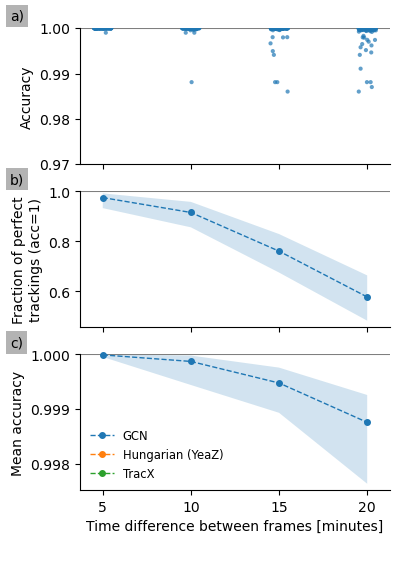

In [37]:
fig, axs = plt.subplot_mosaic([['a)'], ['b)'], ['c)']], figsize=(
    4, 6), sharex=True, tight_layout=True)

axs['b)'].axhline(1.0, color='tab:gray')
axs['b)'].fill_between(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc.frac_perfect_ci_lower[res_agg.method == 'gcn'], res_agg.acc.frac_perfect_ci_higher[res_agg.method == 'gcn'],
                       alpha=0.2)
axs['b)'].plot(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc.frac_perfect[res_agg.method == 'gcn'],
               'o--', markersize=4, linewidth=1,
               label='GCN', clip_on=False)
axs['b)'].fill_between(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc.frac_perfect_ci_lower[res_agg.method == 'yeaz'], res_agg.acc.frac_perfect_ci_higher[res_agg.method == 'yeaz'],
                       alpha=0.2)
axs['b)'].plot(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc.frac_perfect[res_agg.method == 'yeaz'],
               'o--', markersize=4, linewidth=1,
               label='Hungarian (YeaZ)', clip_on=False)
axs['b)'].fill_between(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc.frac_perfect_ci_lower[res_agg.method == 'tracx'], res_agg.acc.frac_perfect_ci_higher[res_agg.method == 'tracx'],
                       alpha=0.2)
axs['b)'].plot(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc.frac_perfect[res_agg.method == 'tracx'],
               'o--', markersize=4, linewidth=1,
               label='TracX', clip_on=False)
# axs['b)'].set_xlabel('Time difference between frames [minutes]')
axs['b)'].set_ylabel('Fraction of perfect\ntrackings (acc=1)')
axs['b)'].spines.top.set_visible(False)
axs['b)'].spines.right.set_visible(False)
# axs['b)'].legend(fontsize='small', frameon=False)
axs['b)'].set_ylim((None, 1.0))

axs['c)'].axhline(1.0, color='tab:gray')
axs['c)'].fill_between(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc['mean_ci_lower'][res_agg.method == 'gcn'], res_agg.acc['mean_ci_higher'][res_agg.method == 'gcn'],
                       alpha=0.2)
axs['c)'].plot(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc['mean'][res_agg.method == 'gcn'],
               'o--', markersize=4, linewidth=1,
               label='GCN', clip_on=False)
axs['c)'].fill_between(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc['mean_ci_lower'][res_agg.method == 'yeaz'], res_agg.acc['mean_ci_higher'][res_agg.method == 'yeaz'],
                       alpha=0.2)
axs['c)'].plot(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc['mean'][res_agg.method == 'yeaz'],
               'o--', markersize=4, linewidth=1,
               label='Hungarian (YeaZ)', clip_on=False)
axs['c)'].fill_between(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc['mean_ci_lower'][res_agg.method == 'tracx'], res_agg.acc['mean_ci_higher'][res_agg.method == 'tracx'],
                       alpha=0.2)
axs['c)'].plot(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc['mean'][res_agg.method == 'tracx'],
               'o--', markersize=4, linewidth=1,
               label='TracX', clip_on=False)
axs['c)'].set_ylabel('Mean accuracy')
axs['c)'].spines.top.set_visible(False)
axs['c)'].spines.right.set_visible(False)
axs['c)'].legend(fontsize='small', frameon=False)
axs['c)'].set_ylim((None, 1.0))
axs['c)'].set_xlabel('Time difference between frames [minutes]')

sns.stripplot(
    data=res, x='timediff', y='acc', hue='method',
    dodge=True, s=3, alpha=0.7, ax=axs['a)'], legend=False, native_scale=True,
    # clip_on=False,
)
axs['a)'].axhline(1.0, color='tab:gray')
# some outliers from YeaZ and trackx are not shown !!
axs['a)'].set_ylim((0.97, 1))
axs['a)'].set_ylabel('Accuracy')
axs['a)'].set_xlabel('Time difference between frames [minutes]')
axs['a)'].set_xticks(res_agg.timediff.unique())
axs['a)'].spines.top.set_visible(False)
axs['a)'].spines.right.set_visible(False)

for label, ax in axs.items():
    # label physical distance in and down
    trans = mtransforms.ScaledTranslation(-0.7, 0.05, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='bottom',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# fig.savefig('../report_gnn/figures/timediff_accuracy.pdf')
plt.show()

### Evaluate p-value from bootstrapped samples


In [38]:
from typing import Callable
from scipy.stats import ttest_ind


def bootstrap_sample(
        x: np.ndarray,
        n: int = 10_000,
        agg: Callable[[np.ndarray], float] = np.mean
) -> np.ndarray:
    """Compute confidence interval of a given data aggregate

    Parameters
    ----------
    x : np.ndarray
            data
    alpha : float, optional
            size of the confidence interval, by default 0.95
    n : int, optional
            number of resamples, by default 1_000
    agg : Callable[[np.ndarray], float], optional
            aggregation function, by default np.mean

    Returns
    -------
    aggs: np.ndarray of length ``n``
    """

    aggs = np.zeros(n)

    for i in range(n):
        # resample data uniformly
        sample = x[np.random.randint(0, len(x), len(x))]
        aggs[i] = agg(sample)

    return np.sort(aggs)

-- timediff = 5.0 --
t-test gcn <-> tracx : Ttest_indResult(statistic=nan, pvalue=nan)
t-test gcn <-> yeaz : Ttest_indResult(statistic=nan, pvalue=nan)
-- timediff = 10.0 --
t-test gcn <-> tracx : Ttest_indResult(statistic=nan, pvalue=nan)
t-test gcn <-> yeaz : Ttest_indResult(statistic=nan, pvalue=nan)
-- timediff = 15.0 --
t-test gcn <-> tracx : Ttest_indResult(statistic=nan, pvalue=nan)
t-test gcn <-> yeaz : Ttest_indResult(statistic=nan, pvalue=nan)
-- timediff = 20.0 --
t-test gcn <-> tracx : Ttest_indResult(statistic=nan, pvalue=nan)
t-test gcn <-> yeaz : Ttest_indResult(statistic=nan, pvalue=nan)


/var/folders/yz/5fptsvbx0ydb7cclzcdsvw000000gp/T/ipykernel_6830/481217566.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (col == 1.0).sum() / len(col)
/var/folders/yz/5fptsvbx0ydb7cclzcdsvw000000gp/T/ipykernel_6830/481217566.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (col == 1.0).sum() / len(col)
/var/folders/yz/5fptsvbx0ydb7cclzcdsvw000000gp/T/ipykernel_6830/481217566.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (col == 1.0).sum() / len(col)
/var/folders/yz/5fptsvbx0ydb7cclzcdsvw000000gp/T/ipykernel_6830/481217566.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (col == 1.0).sum() / len(col)


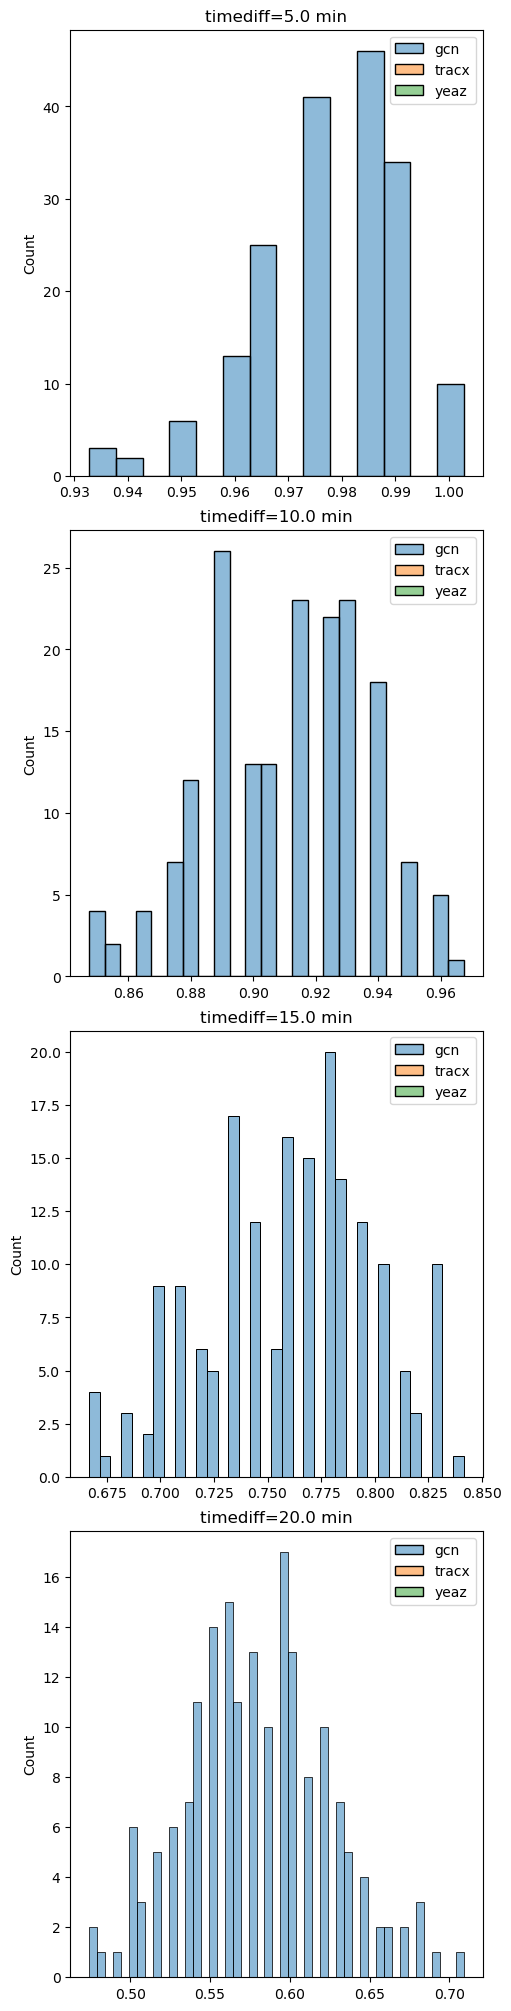

In [39]:
fig, axs = plt.subplots(nrows=res.timediff.nunique(),
                        figsize=(5, 20), constrained_layout=True)

for ax, timediff in zip(axs, res.timediff.unique()):
    print(f'-- timediff = {timediff} --')

    # we resample ~180 times because that's the number of datapoints we have
    sample_gcn = bootstrap_sample(res.query(
        'timediff == @timediff and method == "gcn"').acc.to_numpy(), n=180, agg=frac_perfect)
    sample_tracx = bootstrap_sample(res.query(
        'timediff == @timediff and method == "tracx"').acc.to_numpy(), n=180, agg=frac_perfect)
    sample_yeaz = bootstrap_sample(res.query(
        'timediff == @timediff and method == "yeaz"').acc.to_numpy(), n=180, agg=frac_perfect)

    sns.histplot(dict(gcn=sample_gcn, tracx=sample_tracx,
                 yeaz=sample_yeaz), binwidth=0.005, ax=ax)
    ax.set_title(f'timediff={timediff} min')

    print(f't-test gcn <-> tracx : {ttest_ind(sample_gcn, sample_tracx)}')
    print(f't-test gcn <-> yeaz : {ttest_ind(sample_gcn, sample_yeaz)}')

## What induces mistakes ?


In [40]:
# resultsfile = basedir / \
#     f'results_2023-07-04_20-43-11.csv'
# saved_res = pd.read_csv(resultsfile, index_col=0)

Expected 5->5, got 5->8


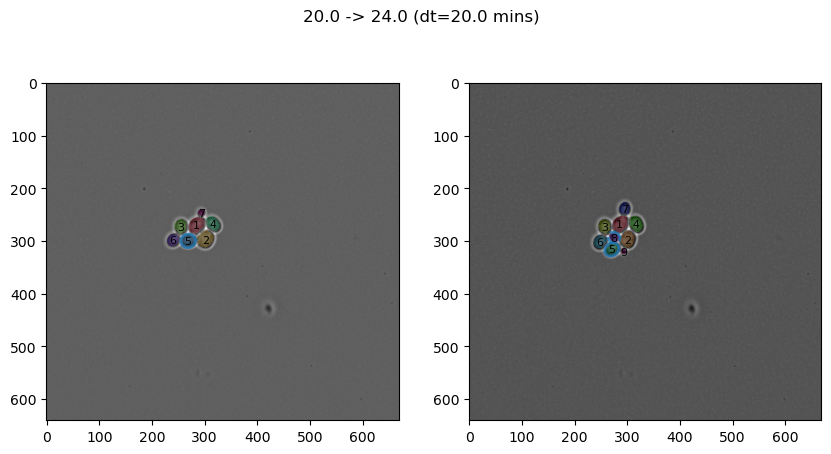

Expected 11->11, got 11->13


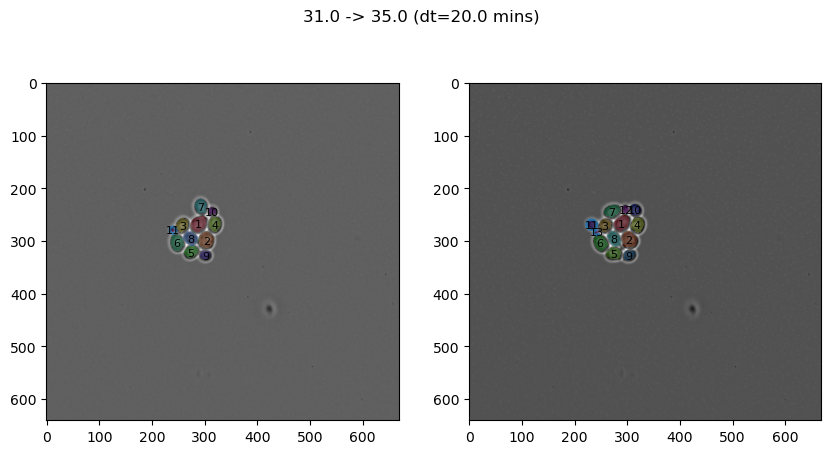

Expected 10->10, got 10->12


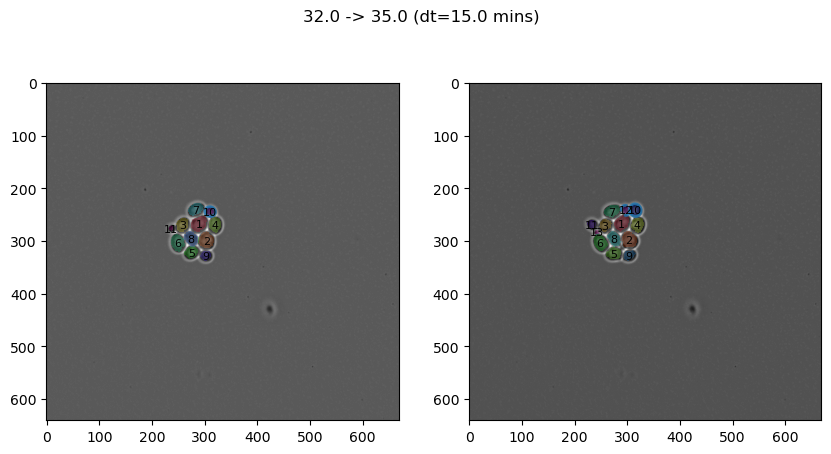

Expected 11->11, got 11->13


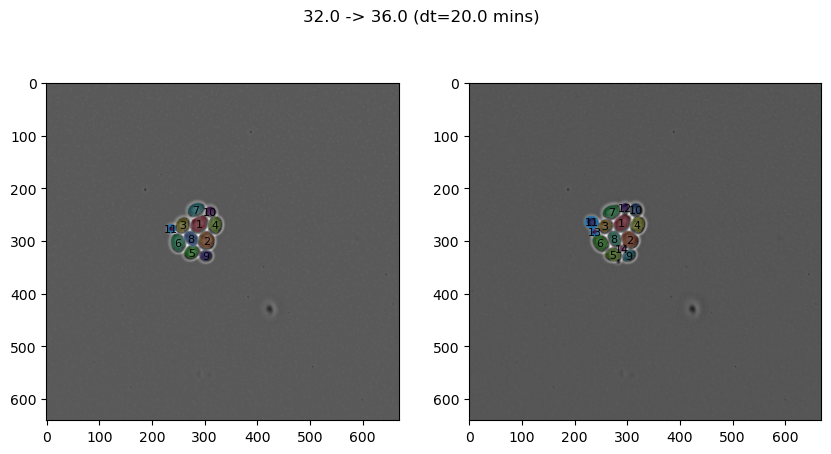

Expected 11->11, got 11->13


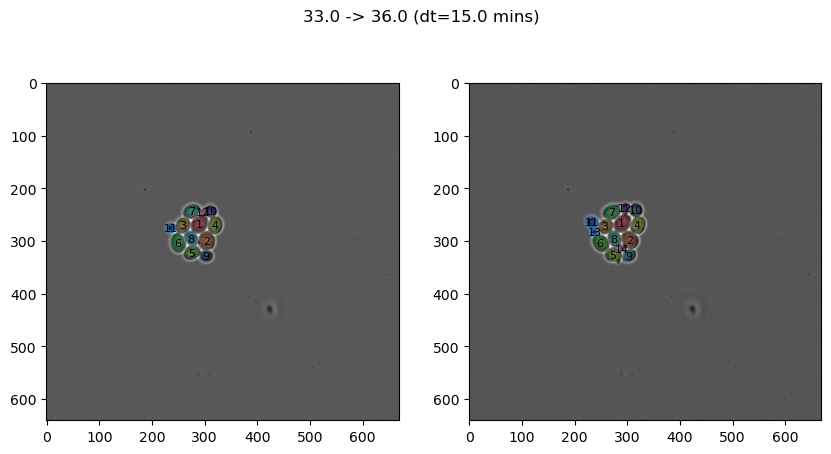

Expected 11->11, got 11->13


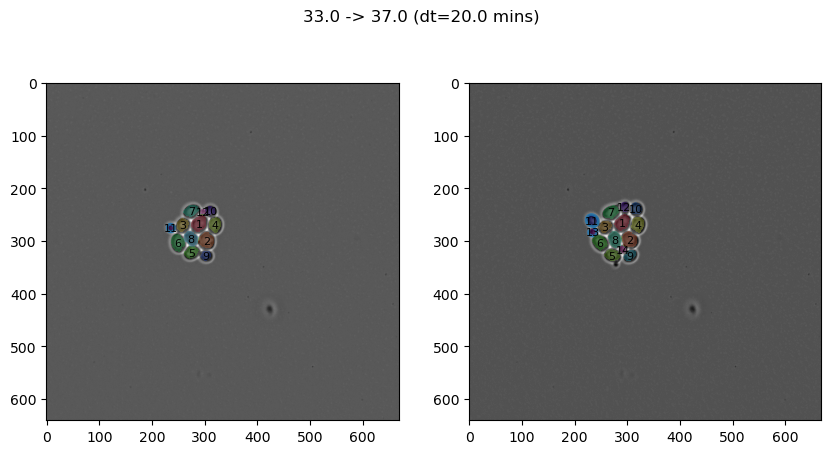

Expected 11->11, got 11->13


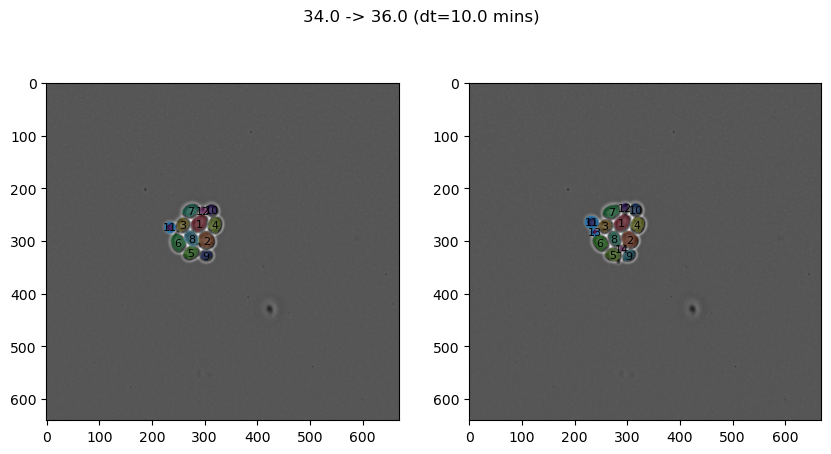

Expected 11->11, got 11->13


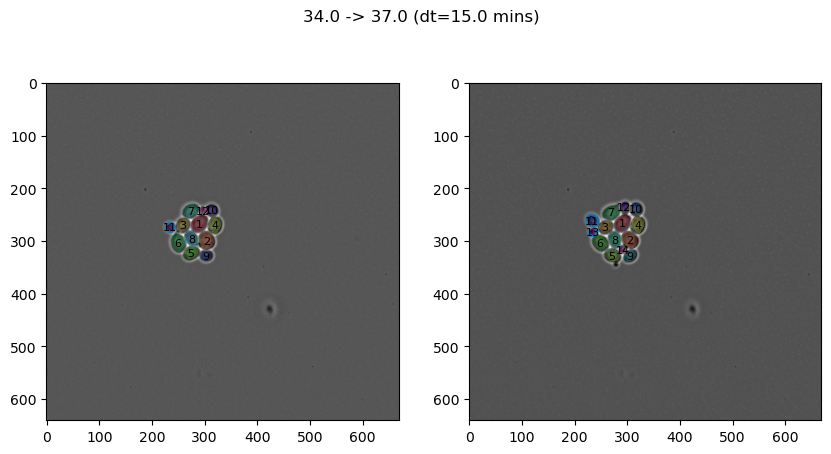

Expected 11->11, got 11->13


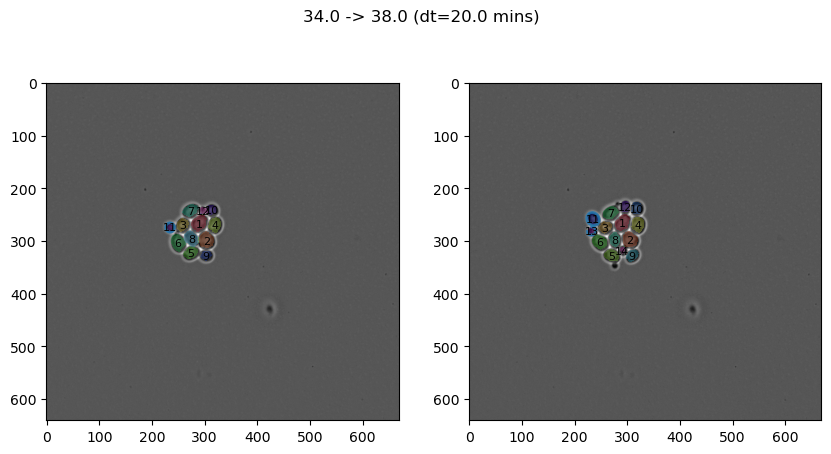

Expected 12->12, got 12->15


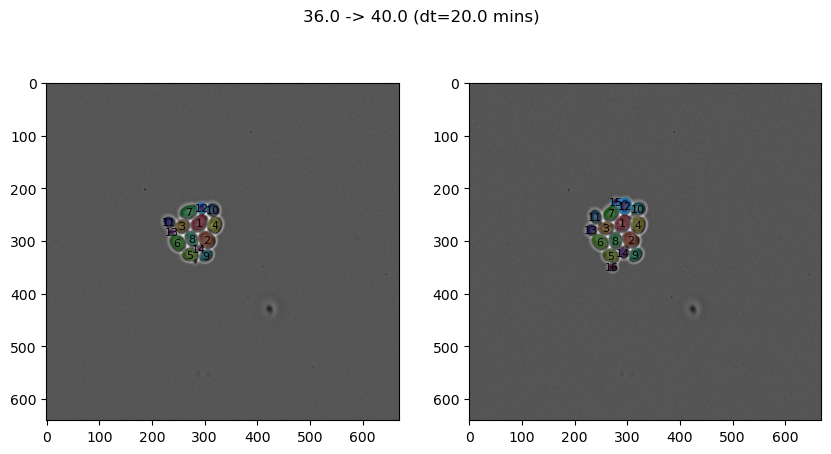

Expected 17->17, got 17->20


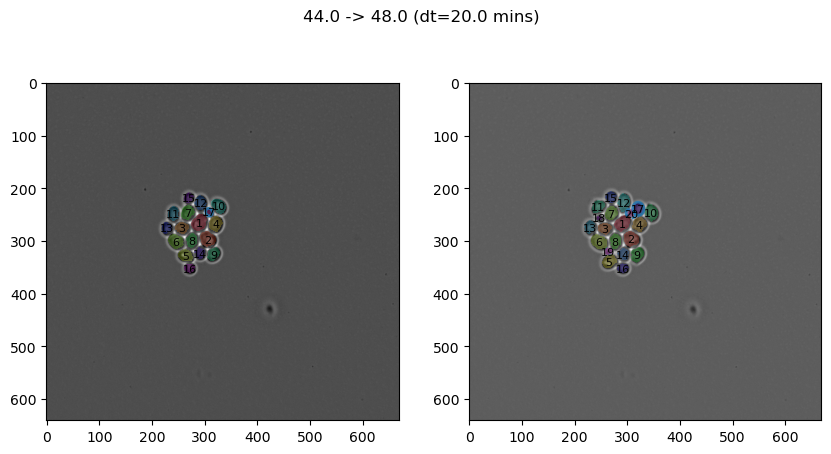

Expected 17->17, got 17->20


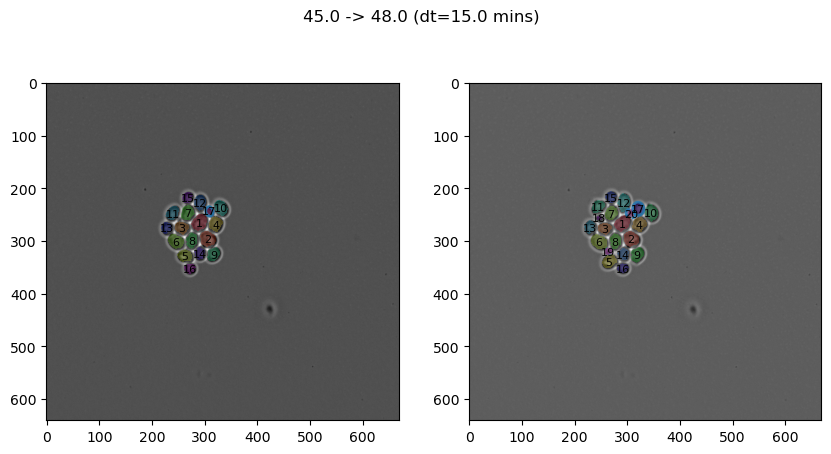

Expected 17->17, got 17->20


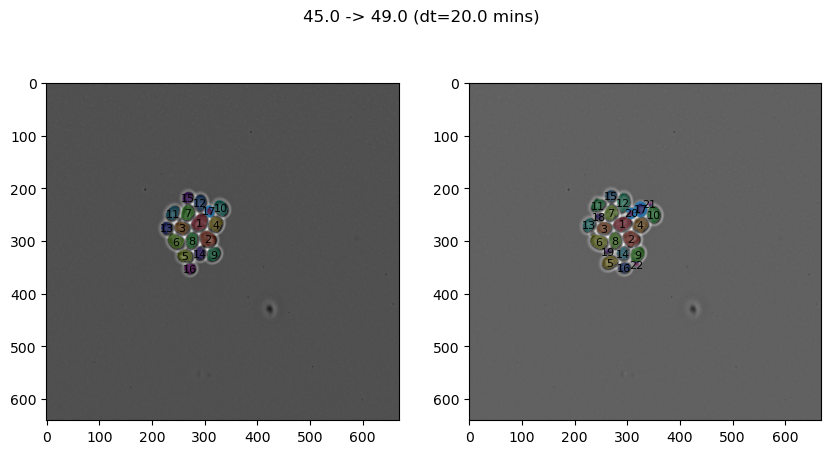

Expected 17->17, got 17->20


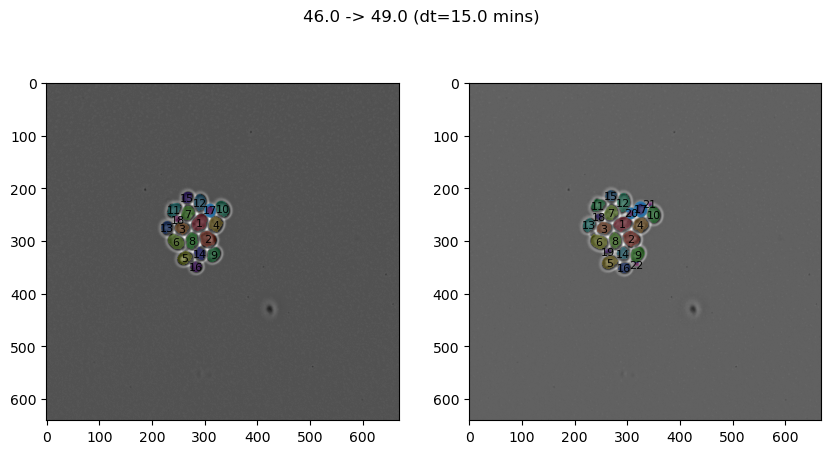

Expected 17->17, got 17->20


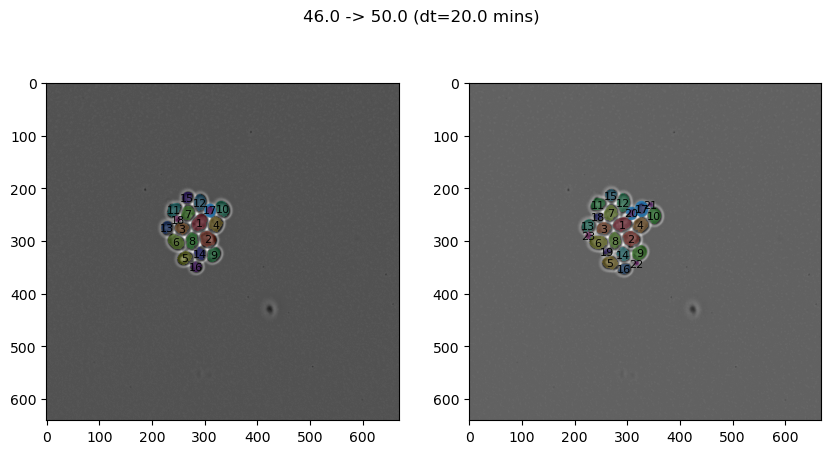

Expected 17->17, got 17->20


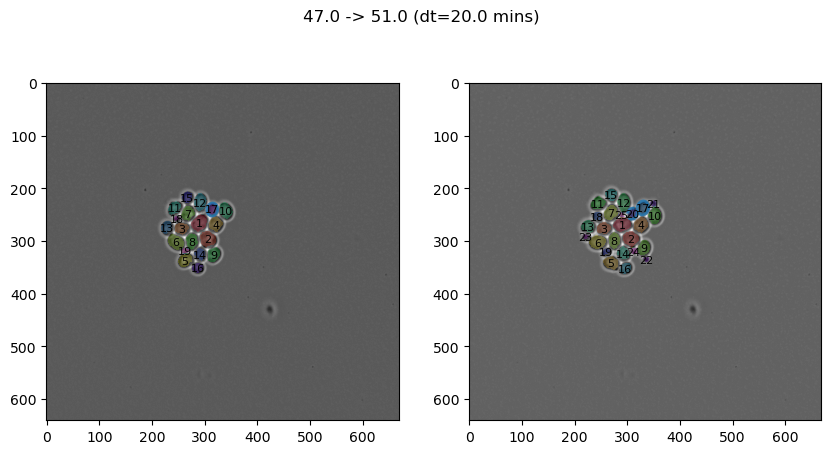

Expected 26->26, got 26->46
Expected 27->27, got 27->47
Expected 32->32, got 32->37
Expected 37->37, got 37->44


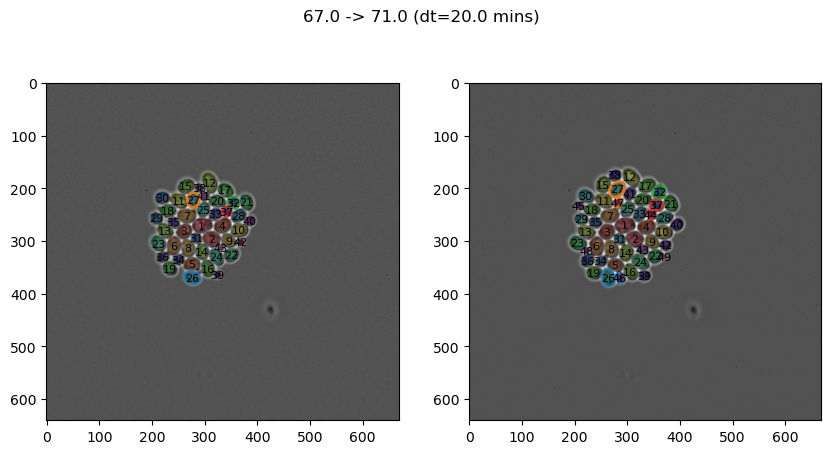

Expected 22->22, got 22->24


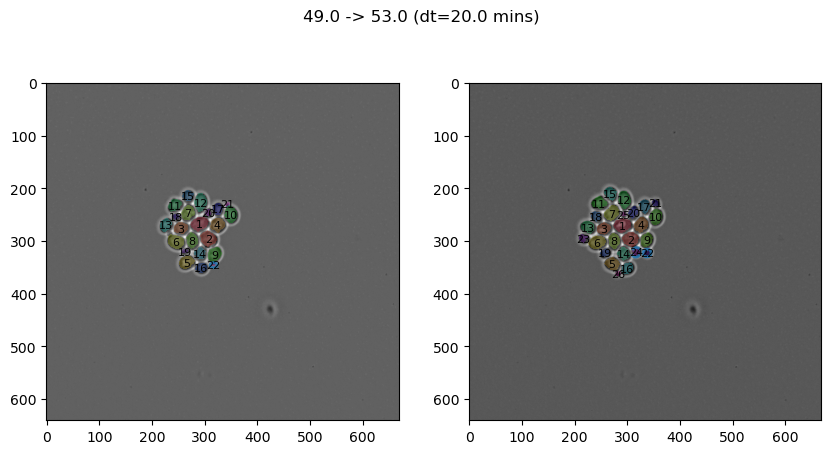

Expected 22->22, got 22->24


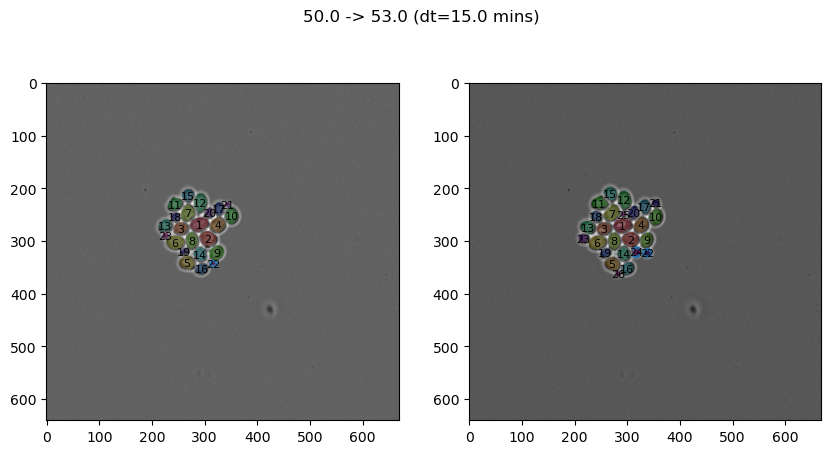

Expected 32->32, got 32->37
Expected 37->37, got 37->44
Expected 39->39, got 39->46


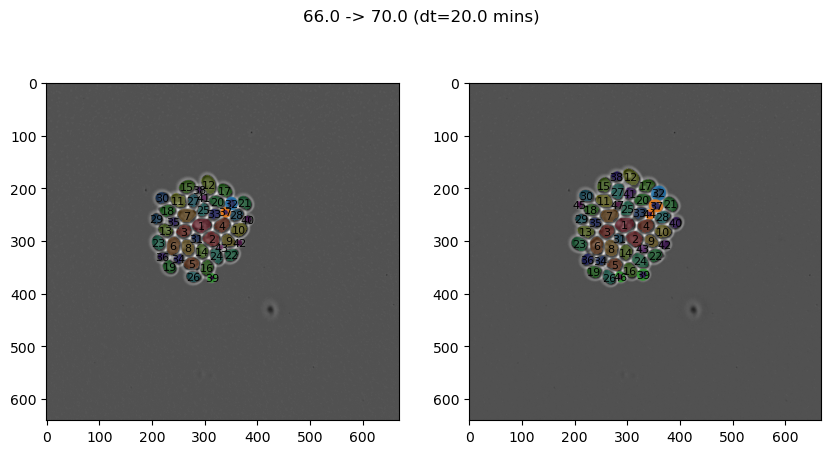

Expected 21->21, got 21->28
Expected 28->28, got 28->37


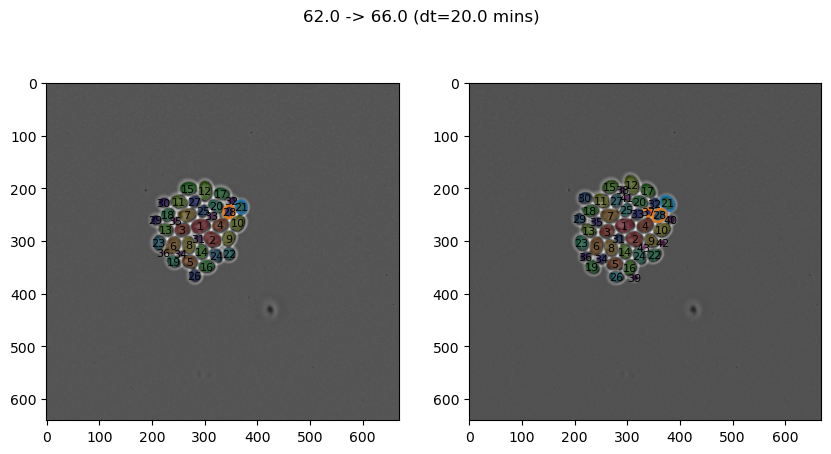

Expected 17->17, got 17->28


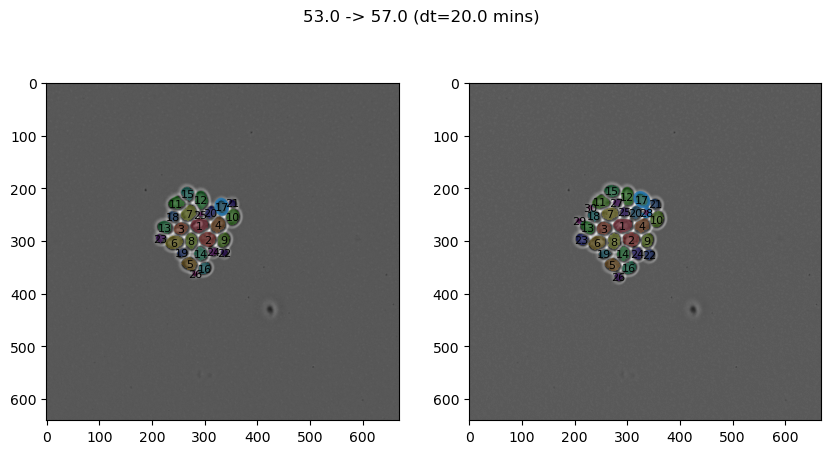

Expected 37->37, got 37->44
Expected 39->39, got 39->46


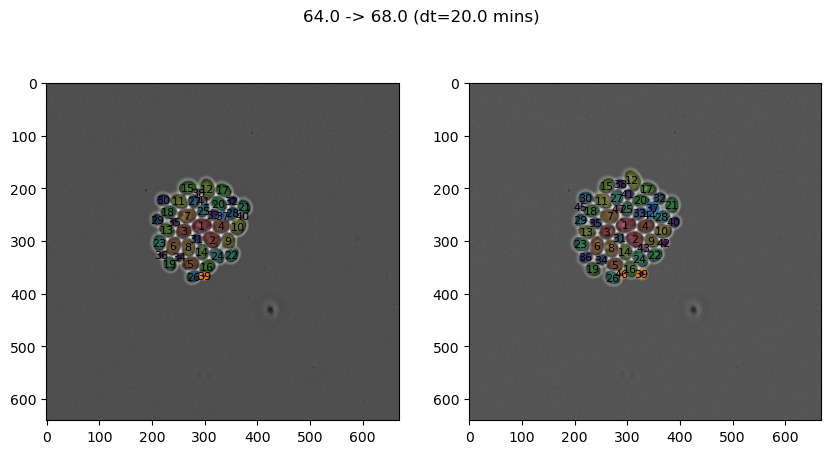

Expected 37->37, got 37->44
Expected 39->39, got 39->46


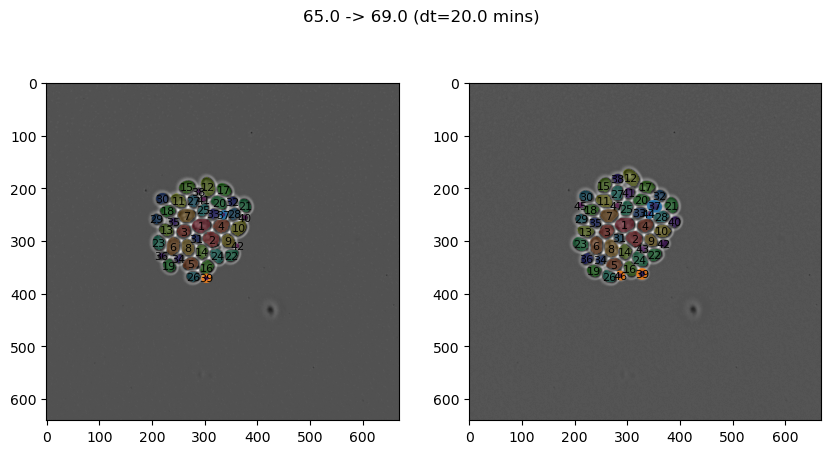

Expected 37->37, got 37->44
Expected 39->39, got 39->46


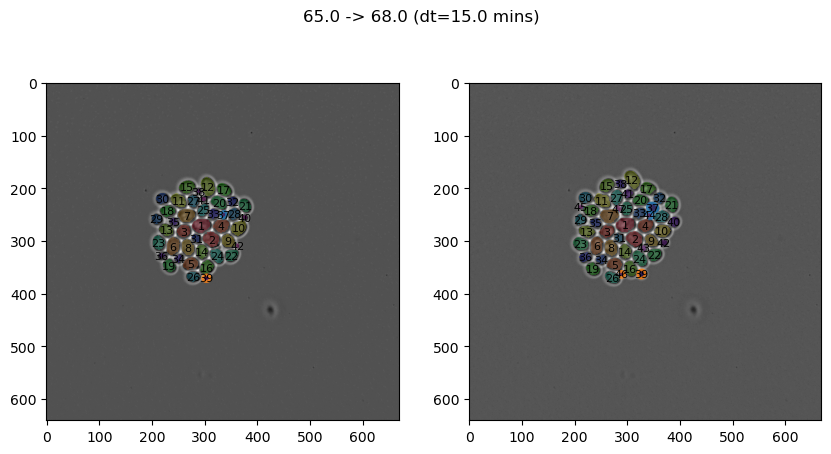

Expected 32->32, got 32->37
Expected 37->37, got 37->44


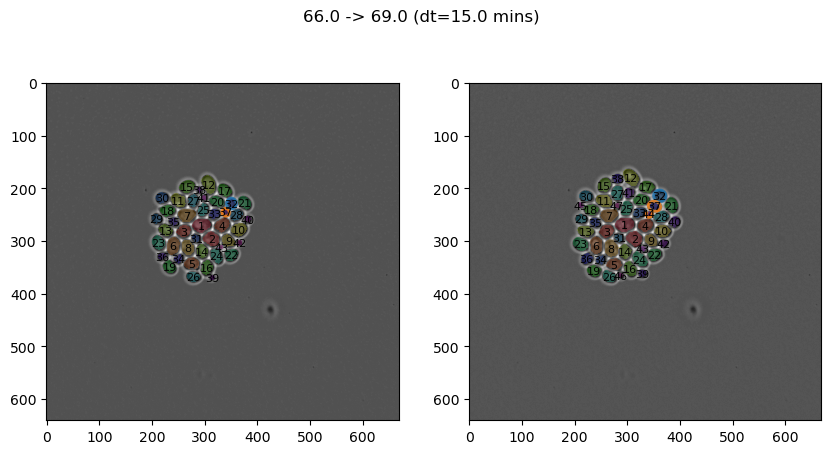

Expected 32->32, got 32->37
Expected 37->37, got 37->44


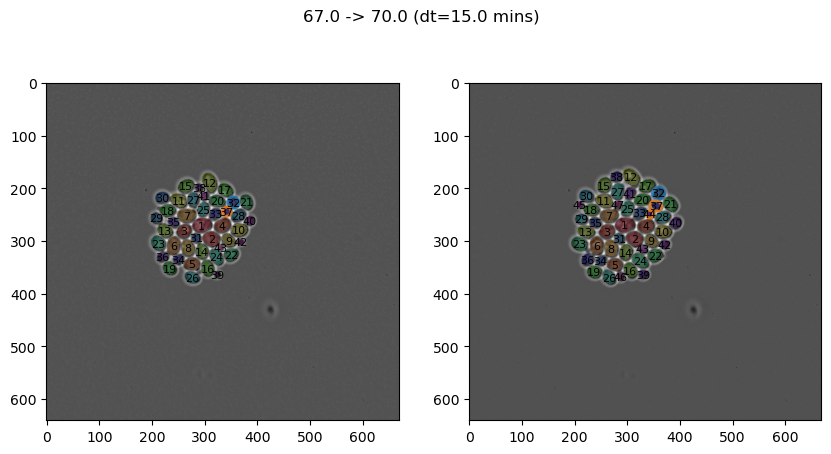

Expected 19->19, got 19->34


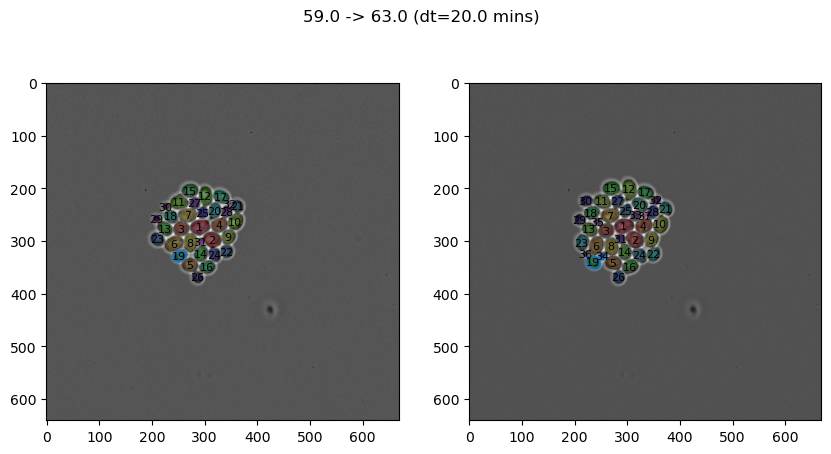

Expected 37->37, got 37->44


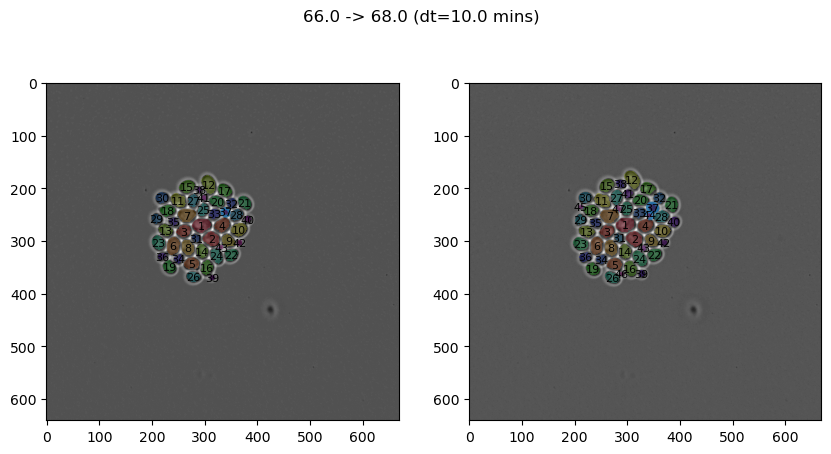

Expected 37->37, got 37->44


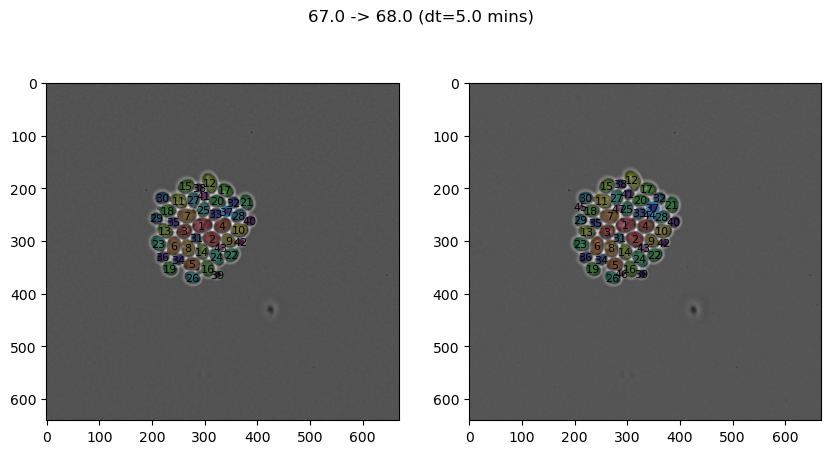

Expected 37->37, got 37->44


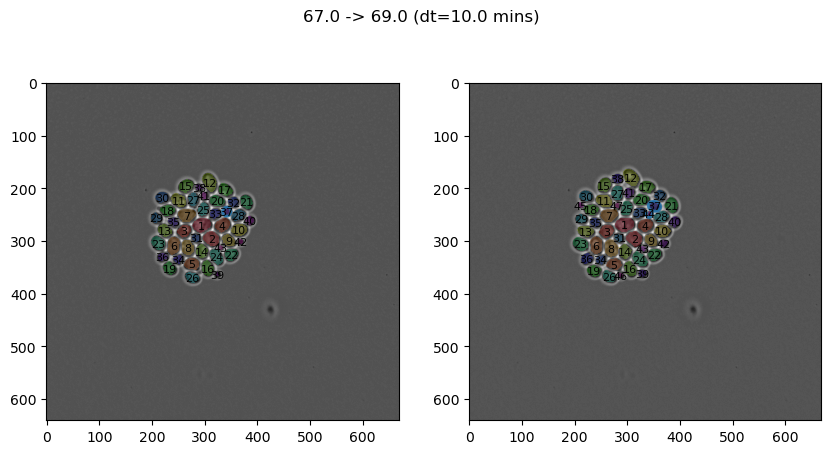

Expected 44->44, got 44->50


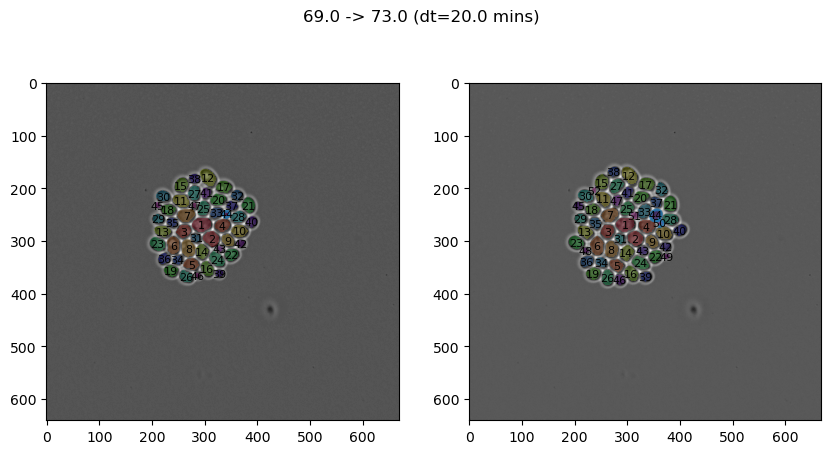

Expected 57->57, got 57->68
Expected 68->68, got 68->71


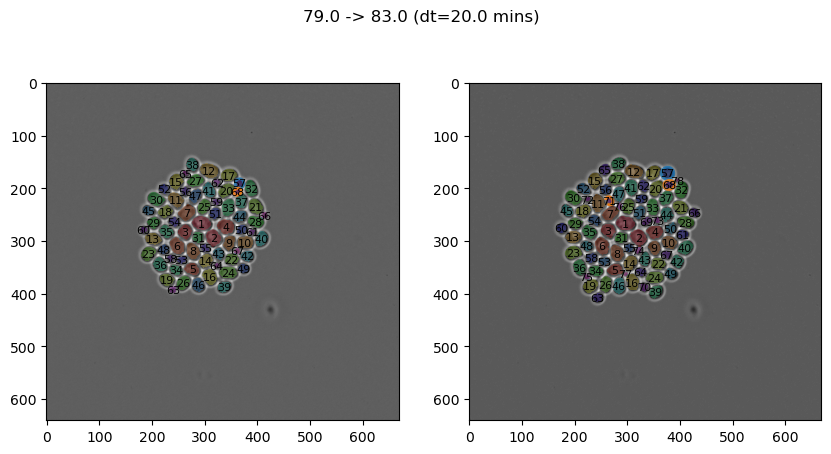

Expected 52->52, got 52->72
Expected 72->72, got 72->84


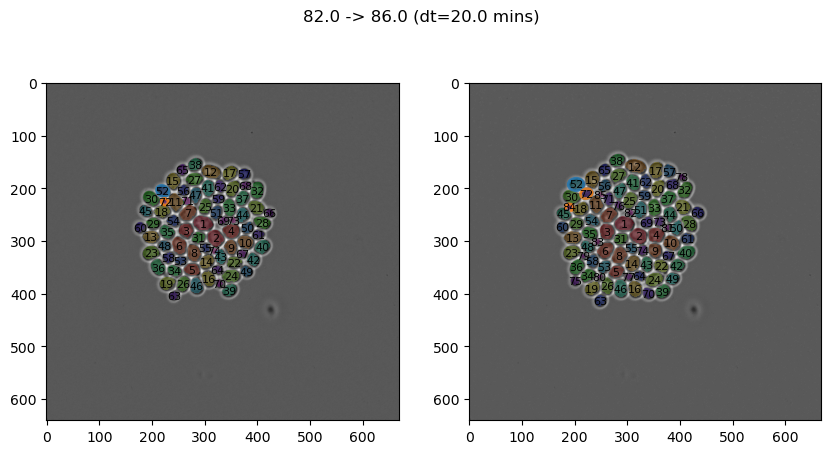

Expected 39->39, got 39->70
Expected 66->66, got 66->124
Expected 70->70, got 70->107
Expected 94->94, got 94->101
Expected 101->101, got 101->156
Expected 107->107, got 107->39
Expected 124->124, got 124->66
Expected 131->131, got 131->192
Expected 140->140, got 140->154
Expected 154->154, got 154->249


StopIteration: 

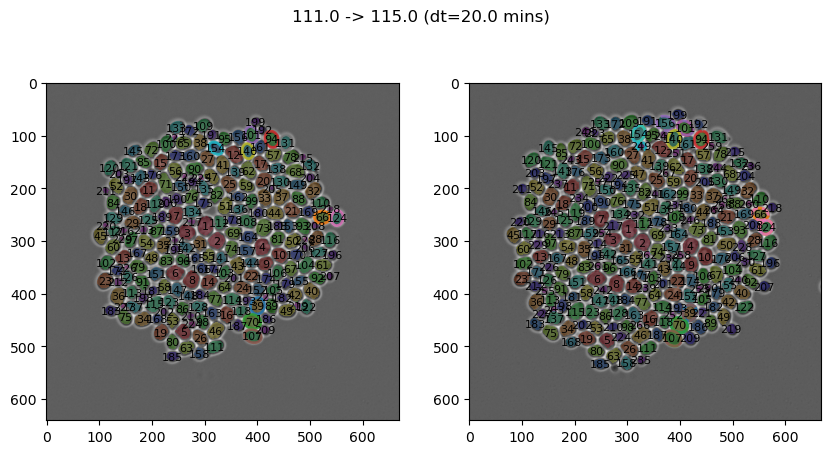

In [46]:
for _, row in res.query('(method == "gcn") and (fp > 0 or fn > 0)').sort_values('acc').iterrows():
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    vis.plot_visible(microscopy, int(row.t1), figax=(fig, axs[0]))
    vis.plot_segmentation(seg, int(row.t1), figax=(
        fig, axs[0]), cellids=True, alpha=0.2)
    vis.plot_visible(microscopy, int(row.t2), figax=(fig, axs[1]))
    vis.plot_segmentation(seg, int(row.t2), figax=(
        fig, axs[1]), cellids=True, alpha=0.2)
    fig.suptitle(f'{row.t1} -> {row.t2} (dt={row.timediff} mins)')
    ga = tracking.build_assgraph(tracking.build_cellgraph(
        feat, int(row.t1), cell_features=dataset_cell_features[1],
        edge_features=dataset_edge_features[0]), tracking.build_cellgraph(feat, int(row.t2), cell_features=dataset_cell_features[1],
                                                                          edge_features=dataset_edge_features[0]), include_target_feature=True)
    gat, *_ = tracking.to_data(ga)
    yhat = net.predict_assignment(gat)
    y = gat.y.cpu().numpy().reshape(yhat.shape)
    cellids1, cellids2 = seg.cell_ids(int(row.t1)), seg.cell_ids(int(row.t2))
    coloriter = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for idx1, (idx2, idx2_hat) in enumerate(zip(np.argmax(y, axis=1), np.argmax(yhat, axis=1))):
        if idx2 != idx2_hat:
            color = next(coloriter)
            print(
                f'Expected {cellids1[idx1]}->{cellids2[idx2]}, got {cellids1[idx1]}->{cellids2[idx2_hat]}')
            vis._vis._plot_ellipse(feat._ellipse(cellids1[idx1], int(row.t1)), figax=(
                fig, axs[0]), color=color, linewidth=2, alpha=0.8, draw_axes=False)
            vis._vis._plot_ellipse(feat._ellipse(cellids2[idx2], int(row.t2)), figax=(
                fig, axs[1]), color=color, linewidth=2, alpha=0.8, draw_axes=False)
            vis._vis._plot_ellipse(feat._ellipse(cellids2[idx2_hat], int(row.t2)), figax=(
                fig, axs[1]), color=color, linestyle='--', linewidth=2, alpha=0.8, draw_axes=False)
    plt.show()